# Website Visits dataset

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.base import  BaseEstimator,RegressorMixin

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **count of page loads**. Your task involves employing bagging and boosting methods to forecast the **count of page loads**. To accomplish this, you will use data from the preceding three days, consisting of **count of page loads**, **count of unique visits**, **count of first time-visits**, **count of returning visits**, and the current **day**.



## Exploring the Website Visitors Dataset
This datatset consists of daily counts of page loads, unique visitors, first-time visitors, and returning visitors for an academic teaching notes website. The dataset contains 2167 rows spanning from September 14, 2014, to August 19, 2020. A visit is defined as a series of hits on one or more pages by the same user on a given day, identified by IP address. Shared IP addresses are considered a single user. A visit is "unique" if a hit from the same IP address hasn't occurred within the last 6 hours. Returning visitors are identified by cookies, and the rest are classified as first-time visitors. The unique visitor count is the sum of returning and first-time visitors.

The dataset consists of the following columns:
- date - date in mm/dd/yyyy format,
- day_of_week - day of the week in text form (Monday, Tuesday, etc.),
- page_loads - daily number of pages loaded,
- unique_visits - daily number of visitors from IP addresses with no hits in over 6 hours,
- first_time_visits - number of unique visitors without a identifying cookie, and
- returning_visits - number of unique visitors minus first-time visitors.

*Note: The dataset is complete, with no missing values in any of its entries.*

In [16]:
data = pd.read_csv("data/website-visitors.csv")
data

,date,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
0,9/14/2014,Sunday,2.146,1.582,1.430,152.0
1,9/15/2014,Monday,3.621,2.528,2.297,231.0
2,9/16/2014,Tuesday,3.698,2.630,2.352,278.0
3,9/17/2014,Wednesday,3.667,2.614,2.327,287.0
4,9/18/2014,Thursday,3.316,2.366,2.130,236.0
...,...,...,...,...,...,...
2162,8/15/2020,Saturday,2.221,1.696,1.373,323.0
2163,8/16/2020,Sunday,2.724,2.037,1.686,351.0
2164,8/17/2020,Monday,3.456,2.638,2.181,457.0
2165,8/18/2020,Tuesday,3.581,2.683,2.184,499.0


In [17]:
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by='date')
data.set_index("date", inplace=True)

In [18]:
data

,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
date,,,,,
2014-09-14,Sunday,2.146,1.582,1.430,152.0
2014-09-15,Monday,3.621,2.528,2.297,231.0
2014-09-16,Tuesday,3.698,2.630,2.352,278.0
2014-09-17,Wednesday,3.667,2.614,2.327,287.0
2014-09-18,Thursday,3.316,2.366,2.130,236.0
...,...,...,...,...,...
2020-08-15,Saturday,2.221,1.696,1.373,323.0
2020-08-16,Sunday,2.724,2.037,1.686,351.0
2020-08-17,Monday,3.456,2.638,2.181,457.0


In [19]:
data.isnull().sum()

day_of_week          0
page_loads           0
unique_visits        0
first_time_visits    0
returning_visits     0
dtype: int64

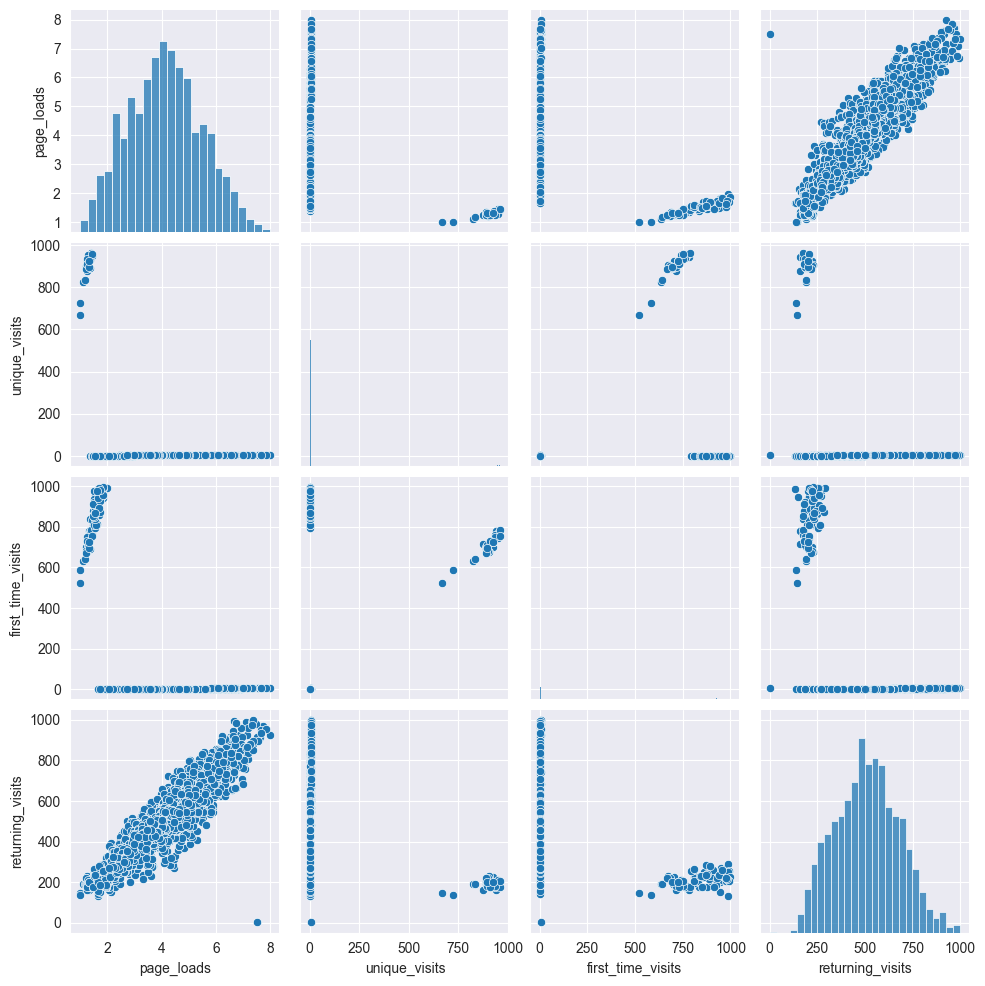

In [20]:
sns.pairplot(data)

<Axes: >

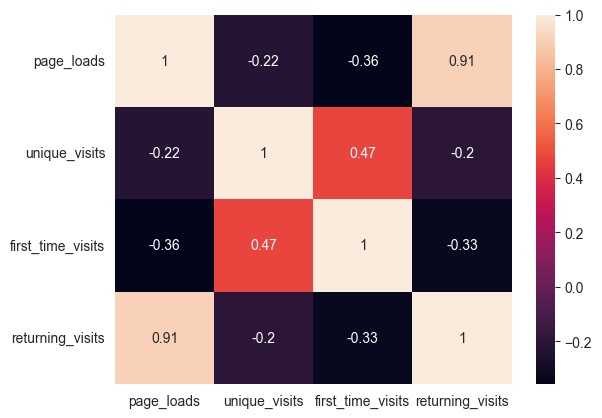

In [21]:
sns.heatmap(data[['page_loads','unique_visits','first_time_visits','returning_visits']].corr(),annot=True)

In [22]:
def label_encoder(df: pd.DataFrame, columns: list):
    for col in columns:
        encoder = LabelEncoder()
        has_null = df[col].isnull().any()
        df[col] = encoder.fit_transform(df[col].astype(str))
        if has_null:
            nan_class  = encoder.transform(['nan'])[0]
            df.loc[df[col]==nan_class, col] = np.nan
    return df

In [23]:
data = label_encoder(data,['day_of_week'])
data

,day_of_week,page_loads,unique_visits,first_time_visits,returning_visits
date,,,,,
2014-09-14,3,2.146,1.582,1.430,152.0
2014-09-15,1,3.621,2.528,2.297,231.0
2014-09-16,5,3.698,2.630,2.352,278.0
2014-09-17,6,3.667,2.614,2.327,287.0
2014-09-18,4,3.316,2.366,2.130,236.0
...,...,...,...,...,...
2020-08-15,2,2.221,1.696,1.373,323.0
2020-08-16,3,2.724,2.037,1.686,351.0
2020-08-17,1,3.456,2.638,2.181,457.0


In [24]:
data['day_of_week'].value_counts()

day_of_week
3    310
1    310
5    310
6    310
4    309
0    309
2    309
Name: count, dtype: int64

In [25]:
data = data.drop(columns=['day_of_week','returning_visits'],axis=1)

## Feauture Extraction 
We want to predict the current  page_load based on the previous features that are 4 days ago

In [26]:
columns = data.columns
for i in range(1,4):
    for col in columns:
        data[f'{col}_shift_-{i}'] =data[col].shift(i)

data.dropna(inplace=True)

In [27]:
data

,page_loads,unique_visits,first_time_visits,page_loads_shift_-1,unique_visits_shift_-1,first_time_visits_shift_-1,page_loads_shift_-2,unique_visits_shift_-2,first_time_visits_shift_-2,page_loads_shift_-3,unique_visits_shift_-3,first_time_visits_shift_-3
date,,,,,,,,,,,,
2014-09-17,3.667,2.614,2.327,3.698,2.630,2.352,3.621,2.528,2.297,2.146,1.582,1.430
2014-09-18,3.316,2.366,2.130,3.667,2.614,2.327,3.698,2.630,2.352,3.621,2.528,2.297
2014-09-19,2.815,1.863,1.622,3.316,2.366,2.130,3.667,2.614,2.327,3.698,2.630,2.352
2014-09-20,1.658,1.118,985.000,2.815,1.863,1.622,3.316,2.366,2.130,3.667,2.614,2.327
2014-09-21,2.288,1.656,1.481,1.658,1.118,985.000,2.815,1.863,1.622,3.316,2.366,2.130
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-15,2.221,1.696,1.373,2.971,2.308,1.922,3.621,2.780,2.322,3.767,2.904,2.477
2020-08-16,2.724,2.037,1.686,2.221,1.696,1.373,2.971,2.308,1.922,3.621,2.780,2.322
2020-08-17,3.456,2.638,2.181,2.724,2.037,1.686,2.221,1.696,1.373,2.971,2.308,1.922


## Train the Models

In [28]:
X,y = data.drop(columns='page_loads',axis=1),data.page_loads
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)

## Ensemble Learning Methods

### Bagging

In [29]:
model_1 = RandomForestRegressor(n_estimators=50,max_depth=5)
model_1.fit(X_train,y_train)

RandomForestRegressor(max_depth=5, n_estimators=50)

In [30]:
preds = model_1.predict(X_test)

In [31]:
print(f'Mean square error: {mean_squared_error(y_test,preds)}')
print(f'R2 score: {r2_score(y_test,preds)}')

Mean square error: 0.10162983746991272
R2 score: 0.9276413084305826


### Boosting

In [32]:
class XGBWrapper(BaseEstimator,RegressorMixin):
    def __init__(self,**kwargs):
        self.params = kwargs
        self.model = XGBRegressor(**kwargs)
    
    def fit(self,X,y):
        self.model = XGBRegressor(**self.params)
        self.model.fit(X,y)
        return self
    
    def predict(self,X):
        return self.model.predict(X)
    
    def set_params(self, **params):
        self.params.update(**params)
        return self
    def get_params(self, deep=True):
        return self.params

In [33]:
model_2 = XGBWrapper(n_estimators=50,max_depth=5)
model_2.fit(X_train,y_train)

XGBWrapper(max_depth=5, n_estimators=50)

Use the trained model to make predictions for the test set.

In [34]:
preds = model_2.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [35]:
print(f'Mean square error: {mean_squared_error(y_test,preds)}')
print(f'R2 score: {r2_score(y_test,preds)}')

Mean square error: 0.05294220768131049
R2 score: 0.9623060611727329


## Fine-tuning the Random Forest Hyperparameter


In [36]:
tcvs = TimeSeriesSplit(n_splits=5)
params = {'max_depth':[5,6,7],
          'n_estimators':[100,200,300,400,500,600],}
grid = GridSearchCV(estimator=RandomForestRegressor(),param_grid=params,cv=tcvs,scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 6, 7],
                         'n_estimators': [100, 200, 300, 400, 500, 600]},
             scoring='neg_mean_squared_error')

In [37]:
best_model = grid.best_estimator_
best_model.fit(X_train,y_train)
preds = best_model.predict(X_test)
print(f'Mean square error: {mean_squared_error(y_test,preds)}')
print(f'R2 score: {r2_score(y_test,preds)}')

Mean square error: 0.09297559837157215
R2 score: 0.9338029774175098
